##  Predict Movies Ratings based on  Youtube Trailer Comments 




### Problem Statement :
use youtube triler text feature to predict the category of movies ratings using classification. I will describe what makes each class charactitaristically unique, describe what is both certain and uncertain using precision and recall as success metrics. 

**Questions to answer during analysis** 


- what is the most comman youtube comments words for each ratings ? 

 
 

## EDA :


#### Import required libraries 

In [2]:
%matplotlib inline

#EDA
import pandas as pd 
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import requests


from collections import Counter
from IPython.display import Image, HTML
from PIL import Image
from datetime import *
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS,ImageColorGenerator

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
import nltk
from nltk.probability import *
from nltk.corpus import stopwords

#neural network preprocessing
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping


#modling
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

#neural network model 

from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model
from keras.layers import  Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential


/Users/ohoudaziz/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/ohoudaziz/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


### Load Dataset  and Examine:
 **we have 3 datasets for our analysis**
 
 - Movie IMDd 
 - Youtube Movie Trailer 
 - Youtube Trailer Comments 
 


In [3]:
movie_imdb_df= pd.read_csv('../datasets/movie_metadata.csv', index_col=0)
movie_yotube_df = pd.read_csv('../datasets/y_movie_df.csv', index_col=0)
comments_df= pd.read_csv('../datasets/comments_data.csv', index_col=0)

In [4]:
# display the first five rows of the movie_imdb_df dataset.
#movie_imdb_df.head()

In [5]:
# display the first five rows of the movie_yotube_df dataset.
#movie_yotube_df.head()

In [6]:
# display the first five rows of the comments_df dataset.
#comments_df.head()

In [7]:
# numbers Observations of each datasets 
print('Observations Number in the movie_imdb_df: {}'.format(len(movie_imdb_df)),'\n')
print('Observations Number in movie_yotube_df: {}'.format(len(movie_yotube_df)),'\n')
print('Observations Number in comments_df: {}'.format(len(comments_df)))

Observations Number in the movie_imdb_df: 5043 

Observations Number in movie_yotube_df: 4147 

Observations Number in comments_df: 34657


In [8]:
# number of features or columns for our datasets 
print('Features Number in movie_imdb_df: {}'.format(len(movie_imdb_df.columns)),'\n')
print('Features Number in movie_yotube_df: {}'.format(len(movie_yotube_df.columns)),'\n')
print('Features Number in  comments_df: {}'.format(len( comments_df.columns)))


Features Number in movie_imdb_df: 27 

Features Number in movie_yotube_df: 5 

Features Number in  comments_df: 2


In [9]:
# columens name for our datasets 
print('columens name in movie_imdb_df: {}'.format(movie_imdb_df.columns),'\n')
print('columens name in movie_yotube_df: {}'.format(movie_yotube_df.columns),'\n')
print('columens name in comments_df: {}'.format(comments_df.columns))


columens name in movie_imdb_df: Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object') 

columens name in movie_yotube_df: Index(['description', 'video_id', 'origin_title', 'poster', 'title'], dtype='object') 

columens name in comments_df: Index(['Comment', 'video_id'], dtype='object')


###  Merge Datasets :
- we need to merge movies from youtube with thier commnts
- also merge dataset from imdb  that contain ratings 

In [10]:
#we need to merge movies from youtubre with thier commnts by video_id
df = comments_df.merge(movie_yotube_df, on="video_id", how = 'inner')
#df.head(3)

In [11]:
#befor merge we need to change columns name that have the same values 
df.rename(columns={'origin_title':'movie_title'}, inplace=True)

#merge datasets 
final_df = movie_imdb_df.merge(df, on='movie_title', how = 'inner')

#save dataset to csv
final_df.to_csv('movies_final_df.csv', encoding='utf-8')

- load the final dataset that contain all data we need 

In [12]:
#load CSV dataset 
data= pd.read_csv('movies_final_df.csv', index_col=0)

In [13]:
data.head(3)

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,Comment,video_id,description,poster,title
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,2009.0,936.0,7.9,1.78,33000,Here waiting for Avatar 2 :),5PSNL1qE6VY,AVATAR takes us to a spectacular world beyond ...,https://i.ytimg.com/vi/5PSNL1qE6VY/default.jpg,Avatar | Official Trailer (HD) | 20th Century FOX
1,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,2009.0,936.0,7.9,1.78,33000,Aang?,5PSNL1qE6VY,AVATAR takes us to a spectacular world beyond ...,https://i.ytimg.com/vi/5PSNL1qE6VY/default.jpg,Avatar | Official Trailer (HD) | 20th Century FOX
2,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,2009.0,936.0,7.9,1.78,33000,It's almost been a decade yet still stands str...,5PSNL1qE6VY,AVATAR takes us to a spectacular world beyond ...,https://i.ytimg.com/vi/5PSNL1qE6VY/default.jpg,Avatar | Official Trailer (HD) | 20th Century FOX


In [14]:
# number of rows and columns 
data.shape

(40784, 32)

In [15]:
# exmain the dataset information 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40784 entries, 0 to 40783
Data columns (total 32 columns):
director_name                39952 non-null object
num_critic_for_reviews       40678 non-null float64
duration                     40719 non-null float64
director_facebook_likes      39952 non-null float64
actor_3_facebook_likes       40714 non-null float64
actor_2_name                 40737 non-null object
actor_1_facebook_likes       40774 non-null float64
gross                        36115 non-null float64
genres                       40784 non-null object
actor_1_name                 40774 non-null object
movie_title                  40784 non-null object
num_voted_users              40784 non-null int64
cast_total_facebook_likes    40784 non-null int64
actor_3_name                 40714 non-null object
facenumber_in_poster         40714 non-null float64
plot_keywords                40085 non-null object
movie_imdb_link              40784 non-null object
num_user_for_review

In [16]:
# describe our target 
#data.content_rating .describe()

In [17]:
# count the values of our targt 
data.content_rating .value_counts()

R            16382
PG-13        14343
PG            6415
G              839
Not Rated      415
Unrated        268
TV-14          252
TV-MA          232
Approved       193
X              100
TV-PG           95
TV-G            55
Passed          37
M               30
GP              20
NC-17           20
TV-Y7           10
TV-Y             3
Name: content_rating, dtype: int64

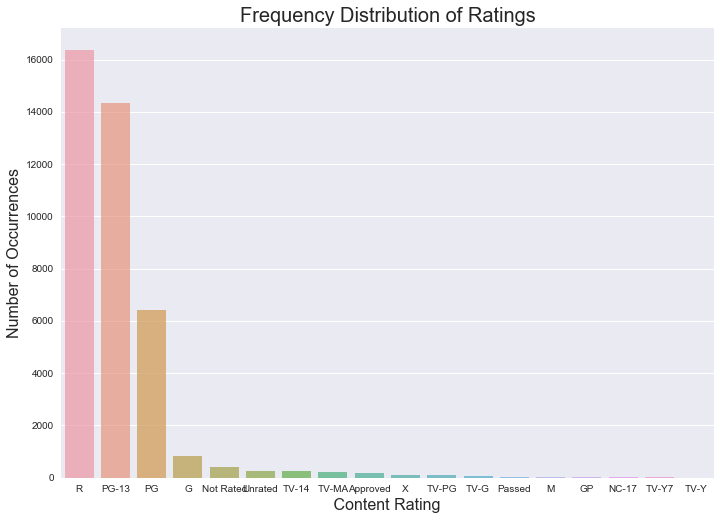

In [18]:
#shows the frequency distribution of the rating column
rating_count = data['content_rating'].value_counts()
sns.set(style="darkgrid",rc={'figure.figsize':(11.7,8.27)})
sns.barplot(rating_count.index, rating_count.values, alpha=0.7)
plt.title('Frequency Distribution of Ratings',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel(' Content Rating ', fontsize=16)
plt.show()

In [19]:
# function to represent poster pict in rater than url
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'

#HTML(data.to_html(escape=False ,formatters=dict(poster=path_to_image_html)))

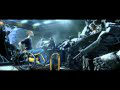

In [20]:
# another code for represent pict of poster 
images=[]
for url in data.poster[0:10]:
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    images.append(img)
images[3]

- actually i can just look at limit numbers of images 

## Data cleaning 

- remove any **duplicate rows** for Unique values (video_id , poster, title, movie )		
- Dealing with **null** values 
- remove **unrated** movies 
- remove ( e-mail , url .... )

In [21]:
# check duplicated rows in one columens 
data.duplicated().sum()

6235

In [22]:
#drop all duplicated rows in datafram 
data.drop_duplicates(keep='first',inplace=True)

In [23]:
data.duplicated().sum()

0

In [66]:
data.shape

(31711, 36)

In [24]:
# check null values 
data.isnull().sum()

director_name                 712
num_critic_for_reviews        106
duration                       65
director_facebook_likes       712
actor_3_facebook_likes         70
actor_2_name                   47
actor_1_facebook_likes         10
gross                        3745
genres                          0
actor_1_name                   10
movie_title                     0
num_voted_users                 0
cast_total_facebook_likes       0
actor_3_name                   70
facenumber_in_poster           70
plot_keywords                 549
movie_imdb_link                 0
num_user_for_reviews           73
language                       60
country                        50
content_rating                981
budget                       2524
title_year                    746
actor_2_facebook_likes         47
imdb_score                      0
aspect_ratio                 1059
movie_facebook_likes            0
Comment                         8
video_id                        0
description   

In [25]:
#fill null 
values = {'description':' no description',
          'aspect_ratio':'',
         'title_year':'',
         'budget':'',
         'country':'',
        'language': '',
        'num_user_for_reviews' :'',
        'plot_keywords' : '',
         'facenumber_in_poster':'',
         'actor_3_name':'',
         'gross': '',
         'actor_3_facebook_likes':'',
         'director_facebook_likes':'',
         'duration':'',
         'num_critic_for_reviews':'',
         'director_name':'',
         'content_rating':'',
         'Comment':'',
         'actor_2_name':'',
         'actor_1_name':'',
         'actor_1_facebook_likes':'',
         'actor_2_facebook_likes':'',
         'title':'',}
data.fillna(value=values,inplace=True)

In [25]:
#data.isnull().sum()

- now after clencing datafram i will clean the text in importent text variables 

In [26]:
# function for clean text 
import re
def text_clean(x):
    x = str(x)
    x = x.replace('W\'', '')
    x = x.replace('[', '')
    x = x.replace(']', '')
    x = x.replace('[', '')
    x = x.replace("'", '')
    x = x.replace('"', '')
    x = x.replace(',', '')
    x = x.replace('.', '')
    x = x.replace('?', '')
    x = x.replace('*', '')
    x = x.replace(':', '')
    x = x.replace('&', '')
    x = x.replace('€', '')
    x = x.replace('@', '')
    x = x.replace(';', '')
    x = x.replace('%', '')
    x = x.replace('®', '')
    x = x.replace('^', '')
    x = x.replace('°', '')
    x = x.replace('¢', '')
    x = x.replace('√', '')
    x = x.replace('=', '')
    x = x.replace('¥', '')
    x = x.replace('{', '')
    x = x.replace('π', '')
    x = x.replace('•', '')
    
    return x

data.Comment = data.Comment.apply(text_clean)
data.description = data.description.apply(text_clean)
data.title = df.title.apply(text_clean)


In [27]:
# fonction for  remove emoji 
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

data.Comment = data.Comment.apply(remove_emoji)
data.description = data.description.apply(remove_emoji)
data.title = df.title.apply(remove_emoji)

In [28]:
##data.Comment

In [29]:
# remove Not Rated  and unrated movies
data= data[data.content_rating !='Not Rated']
data=data[data.content_rating !='unrated']

**stop word**

In [30]:
# I'm not going to do this very thoroughly, but there are a few gibberish words that stood out, and 'film' and
# 'movie' shouldn't be very important either.

stop_words = stopwords.words('english')
stop_words.append('film')
stop_words.append('movie')
stop_words.append('Trailer')
stop_words.append('trailer')
stop_words.append('HD')
stop_words.append('movies')

### Features Engineering

In [31]:
# create new cloumn that contain the title word count 
data['word_count'] = data['Comment'].apply(lambda x: len(str(x).split(" ")))
data[['Comment','word_count']].head()

,Comment,word_count
0,Here waiting for Avatar 2 ),6
1,Aang,1
2,Its almost been a decade yet still stands stro...,21
3,z$$$$,1
4,Where Am IFind Me,4


In [42]:
# this function for convert rating Categories to new Categories
def label_race (row):
        if row['content_rating'] == 'R':
            return 'Adults'
        if row['content_rating'] == 'TV-MA':
            return 'Adults'
        if row['content_rating'] == 'X ':
            return 'Adults'
        if row['content_rating'] == 'NC-17' :
            return 'Adults'
        if row['content_rating'] == 'PG-13' :
            return 'Teenagers'
        if row['content_rating'] == 'PG':
            return 'Teenagers'
        if row['content_rating'] == 'TV-PG':
            return 'Teenagers'
        if row['content_rating'] == 'TV-14':
            return 'Teenagers'
        if row['content_rating']  == 'G':
            return 'all age'
        if row['content_rating']  == 'GP':
            return 'all age'
        if row['content_rating']  == 'TV-Y7':
            return 'all age'
        if row['content_rating']  == 'TV-Y':
            return 'all age'
        if row['content_rating']  == 'M':
            return 'all age'
        if row['content_rating']  == 'TV-G':
            return 'all age'
        
        return 'Other'
        

In [43]:
# create new column from our target to be the new target
data['new_rating']=data.apply(lambda row: label_race (row),axis=1)

In [44]:
#keep all ratings that not equal other 
data=data[data.new_rating !='Other']

In [46]:
def label_race (row):
        if row['new_rating'] == 'Adults':
            return 'Not suitable for teenagers'
        if row['new_rating'] == 'all age':
            return 'suitable for teenagers'
        if row['new_rating']  == 'Teenagers':
            return 'suitable for teenagers'
        
        return 'Other'
# create new column from our target to be the new target
data['binary_rating']=data.apply(lambda row: label_race (row),axis=1)        

In [48]:
data.binary_rating.value_counts()

suitable for teenagers        18105
Not suitable for teenagers    14521
Name: binary_rating, dtype: int64

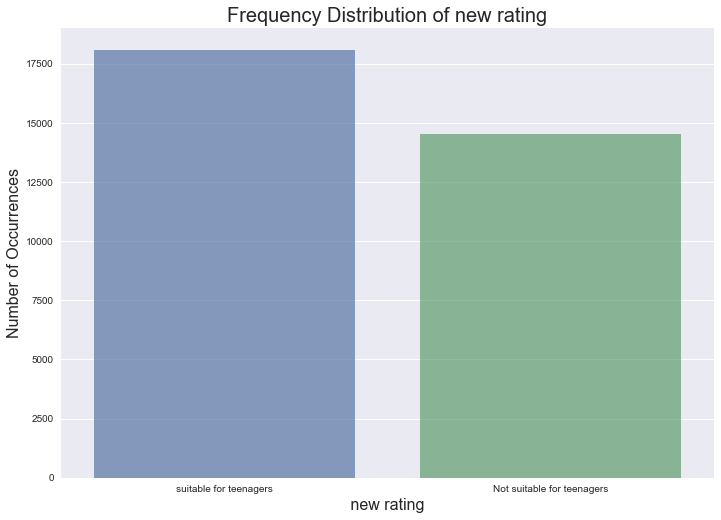

In [50]:
#shows the frequency distribution of the rating column
rating_count = data['binary_rating'].value_counts()
sns.set(style="darkgrid")
sns.barplot(rating_count.index, rating_count.values, alpha=0.7)
plt.title('Frequency Distribution of new rating',fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel(' new rating ', fontsize=16)
plt.show()

### Explore Text 
** in this section i will count the must comman words for each rating value **

### wordcloud for Adults

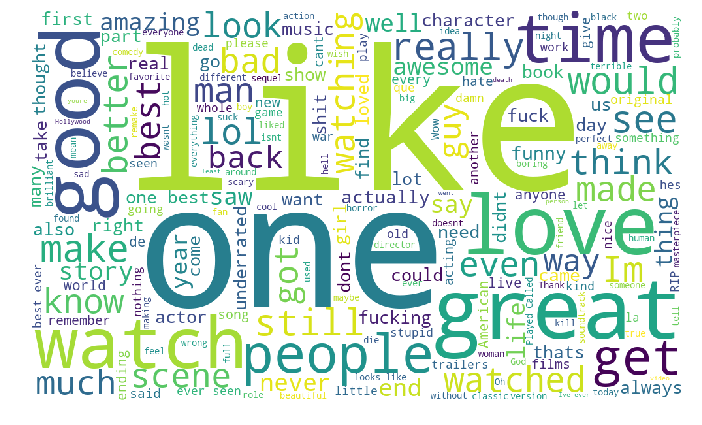

In [51]:
Adults_words = ' '.join(data.loc[data['binary_rating']=='Not suitable for teenagers', 'Comment'])

Adults_wordcloud = WordCloud( 
                      stopwords=stop_words,
                      background_color='white',
                      width=1000,
                      height=600
            ).generate(Adults_words)

plt.imshow(Adults_wordcloud)
plt.axis('off')
plt.show()

### wordcloud for Teenagers

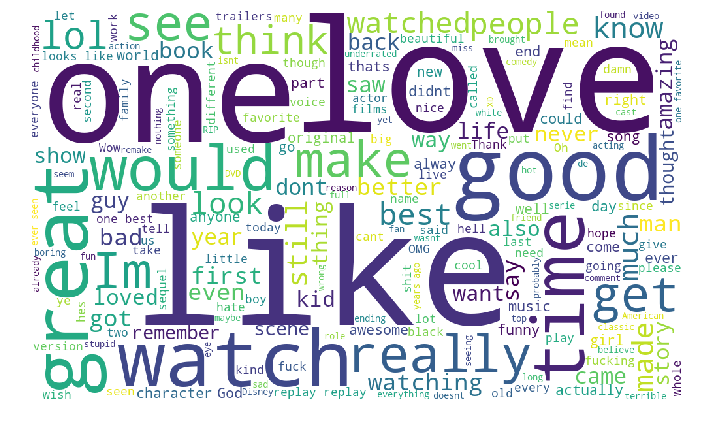

In [52]:
Teenagers_words = ' '.join(data.loc[data['binary_rating']=='suitable for teenagers', 'Comment'])

Teenagers_wordcloud = WordCloud( 
                      stopwords=stop_words,
                      background_color='white',
                      width=1000,
                      height=600
            ).generate(Teenagers_words)

plt.imshow(Teenagers_wordcloud)
plt.axis('off')
plt.show()

** Clean comment ** 

In [53]:
# more cleaning 
all_ = data.Comment

stop_eng = stop_words
customstopwords =[]

tokens = []
sentences = []
tokenizedSentences =[]
for txt in all_:
    sentences.append(txt.lower())
    tokenized = [t.lower().strip(":,.!?") for t in txt.split()]
    tokens.extend(tokenized)
    tokenizedSentences.append(tokenized)

hashtags = [w for w in tokens if w.startswith('#')]
ghashtags = [w for w in tokens if w.startswith('+')]
mentions = [w for w in tokens if w.startswith('@')]
links = [w for w in tokens if w.startswith('http') or w.startswith('www')]
# Comment!
filtered_tokens = [w for w in tokens if not w in stop_eng and not w in customstopwords and w.isalpha() and not len(w)<3 and not w in hashtags and not w in ghashtags and not w in links and not w in mentions]

fd = FreqDist(filtered_tokens)

data['clean_text'] = data.Comment.apply(lambda x: ' '.join([''if w not in fd else w for w in x.split()]))


In [ ]:
#data.isnull().sum()

In [54]:
data=data[data['clean_text']!=' ']

### Feature and Target Preprocessing

In [58]:
# feature selection  
X=data['clean_text']

#convert target by using LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(data.binary_rating)
le.classes_  
y=le.transform(data.binary_rating)

print(max(pd.Series(y).value_counts(normalize=True)))


0.5550439910441172


In [56]:
#train.iloc[:,12:].head()

**Multi-Class Classifier: Features and Design**

To train supervised classifiers, we first transformed the “comment” into a vector of numbers. We explored vector representations such as TF-IDF weighted vectors.
After having this vector representations of the text we can train supervised classifiers to train unseen “comment” and predict the “rating” on which they fall.



In [57]:
# comment tfidf vectorization
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', ngram_range=(1, 2), stop_words=stop_words, encoding='latin-1')
features = tfidf.fit_transform(X).toarray()
labels = y
# train test split 
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state = 0)

In [59]:
features.shape


(31711, 11588)

In [60]:
print(pd.Series(y).value_counts())

1    17601
0    14110
dtype: int64


 - After all the above data transformation, now that we have all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem.


### Modeling :
- Random Forest Classifier
- Linear SVC
- Naive bayes MultinomialNB
- LogisticRegression

In [61]:
# create list contain of classfication models 
models = [
    RandomForestClassifier(n_estimators=200, max_depth=10, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.528649
LogisticRegression        0.538961
MultinomialNB             0.540822
RandomForestClassifier    0.526316
Name: accuracy, dtype: float64

### Models Accuracy Plot 

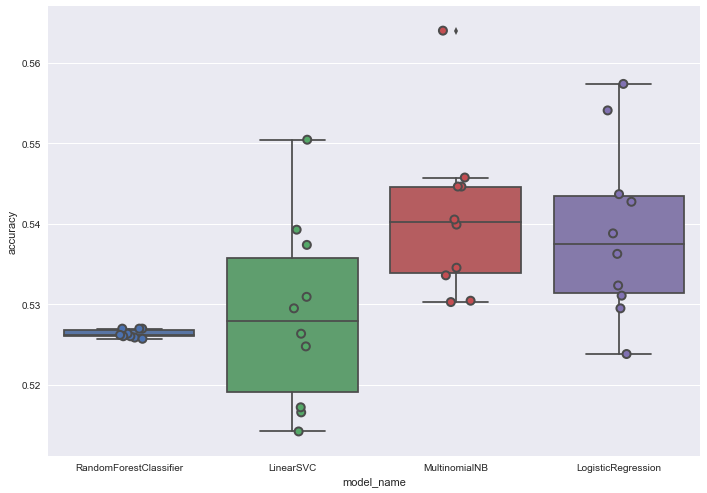

In [62]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


### Model Evaluation 

In [63]:
model = MultinomialNB()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

- metrics 

In [65]:
print(metrics.classification_report(y_test, y_pred, target_names=data['binary_rating'].unique()))

                            precision    recall  f1-score   support

    suitable for teenagers       0.54      0.33      0.41      2813
Not suitable for teenagers       0.56      0.78      0.65      3337

               avg / total       0.54      0.56      0.52      6343



/Users/ohoudaziz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 2
  .format(len(labels), len(target_names))
/Users/ohoudaziz/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###  Multi class classification with LSTM


#####  Target and Features Preprocessing

- Target balence 

In [57]:
#I do aspire here to have balanced classes
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
Teengers = shuffled[shuffled['new_rating'] == 'Teenagers'][:num_of_categories]
Adults = shuffled[shuffled['new_rating'] == 'Adults'][:num_of_categories]

concated = pd.concat([Teengers,Adults], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

 - Convert Target to 0s and 1s

In [58]:
#One-hot encode the lab
concated.loc[concated['new_rating'] == 'Teenagers', 'LABEL'] = 0
concated.loc[concated['new_rating'] == 'Adults', 'LABEL'] = 1


print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=2)
print(labels[:10])
if 'new_rating' in concated.keys():
    concated.drop(['new_rating'], axis=1)
'''
 [1. 0. 0. 0.] Teengers
 [0. 1. 0. 0.] Adults

 
'''

18553    1
11412    0
22550    1
22591    1
26195    1
21438    1
13146    0
9954     0
12552    0
10006    0
Name: LABEL, dtype: int64
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


'\n [1. 0. 0. 0.] Teengers\n [0. 1. 0. 0.] Adults\n\n \n'

 - Feature processing

In [59]:
n_most_common_words = 8000
max_len = 200
tokenizer = Tokenizer(num_words=n_most_common_words, lower=True)
tokenizer.fit_on_texts(concated['clean_text'].values)
sequences = tokenizer.texts_to_sequences(concated['clean_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_ = pad_sequences(sequences, maxlen=max_len)

Found 25128 unique tokens.


- train test split 

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_ , labels, test_size=0.2, random_state=42)

- LSTM model 

In [61]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words,128, input_length=X_.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=10, batch_size=256,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((25368, 200), (25368, 2), (6343, 200), (6343, 2))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 1,073,538
Trainable params: 1,073,538
Non-trainable params: 0
_________________________________________________________________
None
Train on 20294 samples, validate on 5074 samples
Epoch 1/10
20294/20294 [==============================] - 119s 6ms/step - loss: 0.6880 - acc: 0.5503 - val_loss: 0.6882 - val_acc: 0.5471
Epoch 2/10
20294/2029

- Evaluate model 

In [63]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6343/6343 [==============================] - 14s 2ms/step
Test set
  Loss: 0.697
  Accuracy: 0.567


 - plot results 

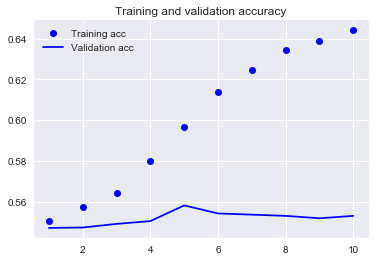

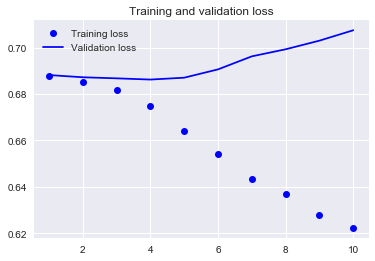

In [65]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()